In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Basic Imports

In [59]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [60]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 100

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [61]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [62]:
from scipy.optimize import minimize

### Ansatz State

In [63]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [64]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [65]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [66]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [67]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [68]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [69]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [70]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [71]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [72]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [73]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [74]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=360, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="COBYLA",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [75]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [76]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [77]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [78]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin=3)
    initialize_approximated_energy_to_list_of_all_approximated_energies()

## Visualization

In [79]:
approximated_energies = []

In [80]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [81]:
def initialize_approximated_energy_to_list_of_all_approximated_energies():
    approximated_energies = []

In [82]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies)
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [83]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

#### Linear Entangelment

In [84]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

27it [00:08,  3.35it/s]
27it [00:09,  2.80it/s]
27it [00:08,  3.16it/s]
27it [00:07,  3.50it/s]
27it [00:08,  3.19it/s]
27it [00:08,  3.27it/s]
27it [00:09,  2.84it/s]
27it [00:07,  3.38it/s]
27it [00:06,  3.96it/s]
27it [00:07,  3.41it/s]
27it [00:07,  3.58it/s]
27it [00:07,  3.47it/s]
27it [00:08,  3.24it/s]
27it [00:07,  3.63it/s]
27it [00:08,  3.19it/s]
27it [00:09,  2.87it/s]
27it [00:08,  3.07it/s]
27it [00:08,  3.17it/s]
27it [00:08,  3.28it/s]
27it [00:08,  3.33it/s]
27it [00:07,  3.47it/s]
27it [00:08,  3.17it/s]
27it [00:08,  3.35it/s]
27it [00:08,  3.26it/s]
27it [00:07,  3.53it/s]
27it [00:08,  3.08it/s]
27it [00:07,  3.70it/s]
27it [00:07,  3.79it/s]
27it [00:07,  3.60it/s]
27it [00:07,  3.47it/s]
27it [00:09,  2.82it/s]
27it [00:09,  2.91it/s]
27it [00:08,  3.28it/s]
27it [00:08,  3.27it/s]
27it [00:07,  3.45it/s]
27it [00:07,  3.66it/s]
27it [00:08,  3.20it/s]
27it [00:06,  3.99it/s]
27it [00:06,  4.05it/s]
27it [00:08,  3.19it/s]
27it [00:07,  3.83it/s]
27it [00:06,  3.

[ 82.18079372 349.47187595  24.31757054 310.79724968 145.91107449
 318.29613702 212.57701501 219.95480938 326.67824262  91.36276402
 271.57834571 351.97506203  15.52689825 212.92587255 292.54224302
 195.72504649  55.99095162 348.21085447 333.98202746 351.92233266
 101.42562665  13.46841324  39.57340491 349.38365845 101.96810509
 309.79819373 139.4225018  138.03506207  43.75869477 234.35791399
 254.82859217  39.67431025]


27it [00:08,  3.19it/s]

CPU times: total: 9min 40s
Wall time: 14min 58s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.774967339277667

Approximation Error
0.011167284357533018


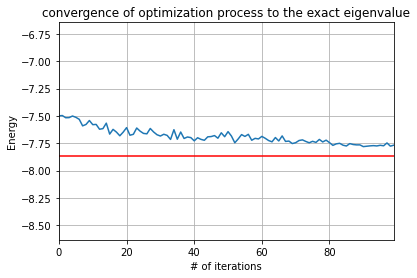

In [85]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

#### Full Entangelment

In [86]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

27it [00:09,  2.86it/s]
27it [00:08,  3.29it/s]
27it [00:08,  3.16it/s]
27it [00:08,  3.09it/s]
27it [00:10,  2.54it/s]
27it [00:08,  3.07it/s]
27it [00:10,  2.53it/s]
27it [00:09,  2.89it/s]
27it [00:09,  2.75it/s]
27it [00:08,  3.05it/s]
27it [00:08,  3.04it/s]
27it [00:08,  3.11it/s]
27it [00:09,  2.84it/s]
27it [00:08,  3.37it/s]
27it [00:08,  3.10it/s]
27it [00:08,  3.01it/s]
27it [00:08,  3.35it/s]
27it [00:08,  3.31it/s]
27it [00:09,  2.96it/s]
27it [00:08,  3.21it/s]
27it [00:07,  3.52it/s]
27it [00:11,  2.29it/s]
27it [00:08,  3.26it/s]
27it [00:08,  3.11it/s]
27it [00:08,  3.17it/s]
27it [00:09,  2.79it/s]
27it [00:09,  2.79it/s]
27it [00:09,  2.75it/s]
27it [00:08,  3.06it/s]
27it [00:07,  3.45it/s]
27it [00:08,  3.14it/s]
27it [00:07,  3.49it/s]
27it [00:08,  3.35it/s]
27it [00:09,  2.91it/s]
27it [00:09,  2.96it/s]
27it [00:08,  3.06it/s]
27it [00:08,  3.04it/s]
27it [00:09,  2.91it/s]
27it [00:08,  3.09it/s]
27it [00:08,  3.13it/s]
27it [00:08,  3.28it/s]
27it [00:07,  3.

[266.91152674  28.12006887 297.88173974 282.31934091  41.64017674
  82.46034171  37.45711941 343.20063324 351.9392084  220.18377589
 241.70747092 318.11097759 316.62115545  87.417739   215.73466064
 178.25754493  84.65810153 260.47614437  44.5378703  339.97931557
  60.03762782 306.12679432  71.93213431  65.58695506 182.64927251
 232.83286429 314.6421073  140.71554577 242.40959915  71.34819634
  59.37157489 309.27067684]


27it [00:08,  3.09it/s]

CPU times: total: 10min 9s
Wall time: 14min 54s


[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.834880710383381

Approximation Error
0.003547406502295336


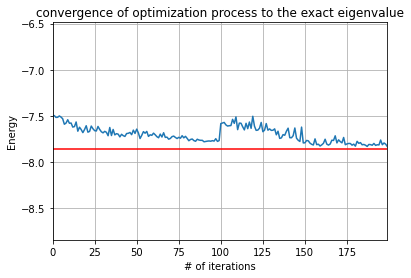

In [87]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [88]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

#### Linear Entangelment

In [89]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

15it [00:04,  3.01it/s]
15it [00:04,  3.12it/s]
15it [00:04,  3.23it/s]
15it [00:04,  3.25it/s]
15it [00:04,  3.13it/s]
15it [00:05,  2.98it/s]
15it [00:04,  3.24it/s]
15it [00:05,  2.88it/s]
15it [00:04,  3.27it/s]
15it [00:04,  3.64it/s]
15it [00:04,  3.17it/s]
15it [00:04,  3.16it/s]
15it [00:04,  3.15it/s]
15it [00:04,  3.41it/s]
15it [00:04,  3.19it/s]
15it [00:04,  3.33it/s]
15it [00:04,  3.13it/s]
15it [00:05,  2.92it/s]
15it [00:04,  3.24it/s]
15it [00:04,  3.50it/s]
15it [00:04,  3.21it/s]
15it [00:05,  2.80it/s]
15it [00:04,  3.54it/s]
15it [00:04,  3.27it/s]
15it [00:04,  3.35it/s]
15it [00:04,  3.25it/s]
15it [00:04,  3.16it/s]
15it [00:04,  3.26it/s]
15it [00:03,  3.92it/s]
15it [00:04,  3.29it/s]
15it [00:05,  2.95it/s]
15it [00:03,  3.87it/s]
15it [00:04,  3.44it/s]
15it [00:04,  3.66it/s]
15it [00:04,  3.08it/s]
15it [00:04,  3.28it/s]
15it [00:04,  3.16it/s]
15it [00:04,  3.05it/s]
15it [00:05,  2.96it/s]
15it [00:04,  3.26it/s]
15it [00:04,  3.18it/s]
15it [00:04,  3.

[357.87763137 261.53236164 259.17729493 192.19643474 242.09006526
 313.46864013 324.96812961 163.69969675  21.78994766  63.15279485
 133.15737949 358.80024775 196.94328248 122.01514096 150.30456348
 210.82555431 354.83652544 104.43851929 106.62368565 294.21589452
  35.46657877 305.61349896 297.44043017 132.82884579 147.43730319
   9.98437792 277.82608649 330.45717674 173.89893876 260.21171804
 126.84454452  15.2849919 ]


15it [00:05,  2.89it/s]

CPU times: total: 5min 27s
Wall time: 7min 52s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.6239652815131058

Approximation Error
0.1256193858719194


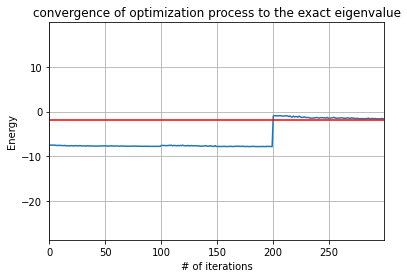

In [90]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [91]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

15it [00:05,  2.61it/s]
15it [00:04,  3.70it/s]
15it [00:04,  3.37it/s]
15it [00:04,  3.51it/s]
15it [00:03,  3.80it/s]
15it [00:05,  2.66it/s]
15it [00:05,  2.72it/s]
15it [00:05,  2.91it/s]
15it [00:05,  2.83it/s]
15it [00:05,  2.75it/s]
15it [00:05,  2.81it/s]
15it [00:04,  3.33it/s]
15it [00:04,  3.36it/s]
15it [00:04,  3.58it/s]
15it [00:04,  3.48it/s]
15it [00:04,  3.15it/s]
15it [00:05,  2.67it/s]
15it [00:04,  3.20it/s]
15it [00:05,  2.73it/s]
15it [00:05,  2.91it/s]
15it [00:05,  2.78it/s]
15it [00:04,  3.11it/s]
15it [00:04,  3.20it/s]
15it [00:04,  3.28it/s]
15it [00:04,  3.23it/s]
15it [00:04,  3.29it/s]
15it [00:04,  3.30it/s]
15it [00:04,  3.53it/s]
15it [00:04,  3.02it/s]
15it [00:05,  2.87it/s]
15it [00:04,  3.13it/s]
15it [00:04,  3.13it/s]
15it [00:04,  3.07it/s]
15it [00:04,  3.04it/s]
15it [00:03,  3.77it/s]
15it [00:04,  3.08it/s]
15it [00:05,  3.00it/s]
15it [00:04,  3.49it/s]
15it [00:04,  3.08it/s]
15it [00:05,  2.79it/s]
15it [00:04,  3.10it/s]
15it [00:05,  2.

[119.32319542  85.65015999 149.22755025 236.65761239 151.53023617
 324.45045317 173.75135747 112.61305674  50.22723001 304.91278856
  72.1231521  270.59612926 167.32584351 295.26272268  49.02666201
  90.54497457  43.80021588  65.2976599  296.46450782 245.48225171
  18.79612376 152.97360044 104.86747391  53.65107359 154.19704244
 209.29201987 222.89104439 101.05290506  48.04925891 218.61411841
 317.40676758 301.61075269]


15it [00:05,  2.80it/s]

CPU times: total: 5min 41s
Wall time: 8min 13s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.7025585475741638

Approximation Error
0.08330294658156077


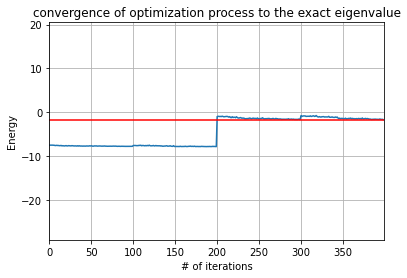

In [92]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [93]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

#### Linear Entangelment

In [94]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

11it [00:04,  2.40it/s]
11it [00:04,  2.26it/s]
11it [00:03,  3.26it/s]
11it [00:03,  3.04it/s]
11it [00:03,  3.30it/s]
11it [00:03,  3.25it/s]
11it [00:03,  3.20it/s]
11it [00:03,  3.35it/s]
11it [00:03,  3.05it/s]
11it [00:03,  3.16it/s]
11it [00:03,  3.60it/s]
11it [00:03,  3.17it/s]
11it [00:03,  2.91it/s]
11it [00:03,  2.76it/s]
11it [00:03,  3.45it/s]
11it [00:03,  3.03it/s]
11it [00:03,  3.17it/s]
11it [00:03,  3.30it/s]
11it [00:03,  3.17it/s]
11it [00:03,  3.59it/s]
11it [00:03,  3.60it/s]
11it [00:04,  2.54it/s]
11it [00:04,  2.48it/s]
11it [00:03,  3.08it/s]
11it [00:03,  3.59it/s]
11it [00:02,  3.89it/s]
11it [00:03,  2.76it/s]
11it [00:03,  3.45it/s]
11it [00:03,  3.24it/s]
11it [00:03,  2.90it/s]
11it [00:03,  2.88it/s]
11it [00:03,  2.80it/s]
11it [00:03,  3.53it/s]
11it [00:03,  2.89it/s]
11it [00:03,  3.05it/s]
11it [00:03,  2.77it/s]
11it [00:03,  2.78it/s]
11it [00:03,  3.60it/s]
11it [00:03,  3.49it/s]
11it [00:03,  2.87it/s]
11it [00:03,  3.05it/s]
11it [00:03,  2.

[145.19806195 150.65651373 343.60005047 218.98830029 274.29804686
 282.33861987 348.99250854 247.36913407 159.57929242  44.21719752
 304.09856421  32.12237567 332.77754666 291.39034746 185.53029881
 247.51316614 167.42153763 293.195874   188.49230074 109.78991842
 192.58528411 178.61647023 136.11071901 165.35220726 298.59081188
 346.72468907 268.48533524 161.66727964 331.19900576 341.98074406
  96.41681105 239.27752867]


11it [00:03,  2.77it/s]

CPU times: total: 4min 17s
Wall time: 6min 12s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-1.638691240879889

Approximation Error
0.18044358146731795


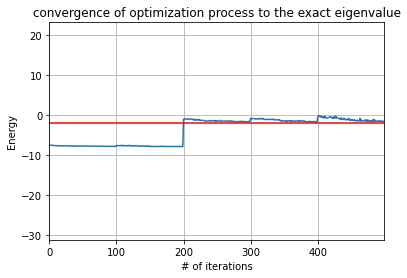

In [95]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [96]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

11it [00:03,  2.93it/s]
11it [00:03,  2.80it/s]
11it [00:03,  3.24it/s]
11it [00:03,  3.07it/s]
11it [00:03,  3.64it/s]
11it [00:03,  2.83it/s]
11it [00:04,  2.54it/s]
11it [00:04,  2.72it/s]
11it [00:04,  2.56it/s]
11it [00:04,  2.72it/s]
11it [00:03,  3.19it/s]
11it [00:03,  3.12it/s]
11it [00:03,  3.20it/s]
11it [00:03,  2.81it/s]
11it [00:03,  3.19it/s]
11it [00:03,  3.29it/s]
11it [00:03,  2.91it/s]
11it [00:03,  2.79it/s]
11it [00:03,  2.93it/s]
11it [00:03,  3.22it/s]
11it [00:04,  2.54it/s]
11it [00:04,  2.74it/s]
11it [00:03,  3.38it/s]
11it [00:03,  2.81it/s]
11it [00:03,  3.30it/s]
11it [00:03,  3.05it/s]
11it [00:04,  2.64it/s]
11it [00:03,  3.41it/s]
11it [00:03,  3.19it/s]
11it [00:04,  2.74it/s]
11it [00:03,  2.93it/s]
11it [00:03,  3.02it/s]
11it [00:03,  3.04it/s]
11it [00:03,  3.18it/s]
11it [00:03,  3.36it/s]
11it [00:03,  3.01it/s]
11it [00:04,  2.65it/s]
11it [00:03,  2.99it/s]
11it [00:03,  2.95it/s]
11it [00:03,  3.41it/s]
11it [00:03,  3.06it/s]
11it [00:03,  3.

[230.97419524  43.94405856 151.9755477   73.04291188   3.94290807
  87.20644464 323.13566719 225.12163738 292.57865146 182.0547051
  50.2236636  158.5776391  144.58336891 128.00940423 143.45999946
 121.68029077 324.88169729  50.44654165 291.24142881 111.11894232
 286.88309649 193.61337672 332.12650127 212.35484515 181.10835113
 228.94459079  78.46903918 130.30829306  56.91032906 316.84500007
 207.73606585 183.58079007]


11it [00:02,  3.71it/s]

CPU times: total: 4min 12s
Wall time: 6min 9s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-1.8023201443703776

Approximation Error
0.09860808081431607


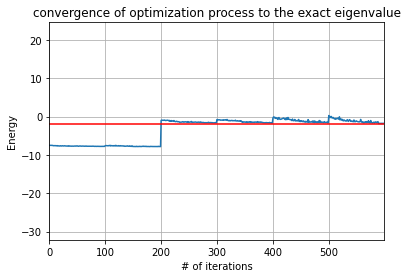

In [97]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [98]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 100

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [99]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

#### Linear Entangelment

In [100]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

7it [00:01,  4.28it/s]
7it [00:01,  4.08it/s]
7it [00:01,  4.41it/s]
7it [00:01,  3.92it/s]
7it [00:01,  4.83it/s]
7it [00:01,  3.65it/s]
7it [00:01,  3.80it/s]
7it [00:01,  4.24it/s]
7it [00:01,  3.75it/s]
7it [00:01,  3.95it/s]
7it [00:01,  4.18it/s]
7it [00:02,  3.40it/s]
7it [00:01,  4.50it/s]
7it [00:01,  4.28it/s]
7it [00:02,  3.44it/s]
7it [00:02,  3.06it/s]
7it [00:01,  4.31it/s]
7it [00:01,  4.59it/s]
7it [00:01,  4.99it/s]
7it [00:01,  4.29it/s]
7it [00:01,  4.88it/s]
7it [00:01,  5.03it/s]
7it [00:01,  5.24it/s]
7it [00:01,  4.31it/s]
7it [00:01,  5.25it/s]
7it [00:01,  4.24it/s]
7it [00:02,  3.48it/s]
7it [00:01,  3.80it/s]
7it [00:01,  4.11it/s]
7it [00:01,  4.38it/s]
7it [00:01,  4.26it/s]
7it [00:01,  4.82it/s]
7it [00:01,  3.71it/s]
7it [00:01,  4.32it/s]
7it [00:01,  3.93it/s]
7it [00:01,  4.10it/s]
7it [00:01,  4.43it/s]
7it [00:01,  4.37it/s]
7it [00:01,  3.57it/s]
7it [00:01,  3.64it/s]
7it [00:01,  5.32it/s]
7it [00:01,  3.96it/s]
7it [00:01,  4.26it/s]
7it [00:01,

[152.31788123 270.10913698  28.94426333 103.23062865 100.00300448
   6.40473541 147.18634677 308.20020688  62.86431864 281.55396727
 257.49126436  70.23630258 261.53636507 196.23613413  44.64059567
 344.41732706  66.43765406 180.06420548 246.17955907 306.56029384
  34.23517364 324.65523005 105.32725175 124.73417687]


7it [00:01,  4.21it/s]

CPU times: total: 2min 1s
Wall time: 2min 54s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-1.0131369892957531

Approximation Error
0.10556382093713199


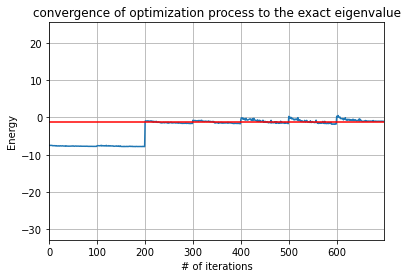

In [101]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [102]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

7it [00:01,  5.05it/s]
7it [00:01,  4.20it/s]
7it [00:01,  3.85it/s]
7it [00:01,  4.35it/s]
7it [00:01,  4.83it/s]
7it [00:01,  4.55it/s]
7it [00:01,  4.62it/s]
7it [00:01,  3.50it/s]
7it [00:01,  3.81it/s]
7it [00:01,  4.40it/s]
7it [00:01,  4.42it/s]
7it [00:01,  4.14it/s]
7it [00:01,  4.50it/s]
7it [00:01,  3.68it/s]
7it [00:01,  4.07it/s]
7it [00:01,  3.53it/s]
7it [00:02,  3.46it/s]
7it [00:01,  4.36it/s]
7it [00:01,  4.54it/s]
7it [00:01,  4.61it/s]
7it [00:01,  3.90it/s]
7it [00:01,  3.97it/s]
7it [00:01,  4.21it/s]
7it [00:01,  3.52it/s]
7it [00:01,  4.18it/s]
7it [00:01,  4.01it/s]
7it [00:01,  3.99it/s]
7it [00:01,  5.34it/s]
7it [00:01,  4.74it/s]
7it [00:01,  4.63it/s]
7it [00:01,  4.85it/s]
7it [00:01,  4.36it/s]
7it [00:01,  4.57it/s]
7it [00:01,  4.15it/s]
7it [00:01,  4.36it/s]
7it [00:01,  4.15it/s]
7it [00:02,  3.34it/s]
7it [00:01,  4.18it/s]
7it [00:01,  4.16it/s]
7it [00:01,  4.35it/s]
7it [00:01,  3.56it/s]
7it [00:01,  4.12it/s]
7it [00:01,  4.44it/s]
7it [00:02,

[321.95946085 320.16131331  60.91279856 180.47996054  75.73754682
 218.77225454 211.60678428  77.8282774  128.019252   181.55036132
 350.09341272 346.91398379 350.00084788 122.72139083 271.03173415
 153.68185985 197.20578839 270.03722872 138.62320669 208.92852842
  36.29927022  17.5314816   29.01122419 198.66478173]


7it [00:02,  3.39it/s]

CPU times: total: 2min
Wall time: 3min


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.9818345903717259

Approximation Error
0.13319877887956222


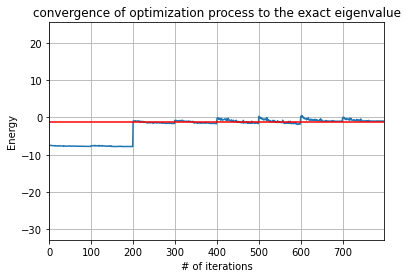

In [103]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [104]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 100

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [105]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

#### Linear Entangelment

In [106]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

3it [00:00,  6.51it/s]
3it [00:00,  6.92it/s]
3it [00:00,  6.56it/s]
3it [00:00,  4.99it/s]
3it [00:00,  7.47it/s]
3it [00:00,  6.20it/s]
3it [00:00,  6.87it/s]
3it [00:00,  7.48it/s]
3it [00:00,  7.74it/s]
3it [00:00,  5.70it/s]
3it [00:00,  5.97it/s]
3it [00:00,  5.88it/s]
3it [00:00,  4.91it/s]
3it [00:00,  4.70it/s]
3it [00:00,  4.37it/s]
3it [00:00,  4.52it/s]
3it [00:00,  4.46it/s]
3it [00:00,  6.64it/s]
3it [00:00,  8.10it/s]
3it [00:00,  6.44it/s]
3it [00:00,  6.76it/s]
3it [00:00,  5.27it/s]
3it [00:00,  5.81it/s]
3it [00:00,  5.67it/s]
3it [00:00,  5.71it/s]
3it [00:00,  5.15it/s]
3it [00:00,  4.36it/s]
3it [00:00,  5.39it/s]
3it [00:00,  5.00it/s]
3it [00:00,  7.17it/s]
3it [00:00,  6.40it/s]
3it [00:00,  5.62it/s]
3it [00:00,  6.86it/s]
3it [00:00,  7.70it/s]
3it [00:00,  6.18it/s]
3it [00:00,  6.41it/s]
3it [00:00,  5.30it/s]
3it [00:00,  7.04it/s]
3it [00:00,  6.23it/s]
3it [00:00,  6.67it/s]
3it [00:00,  6.39it/s]
3it [00:00,  5.55it/s]
3it [00:00,  5.76it/s]
3it [00:00,

[147.16197028 175.88789146 110.95177482 142.27540984  38.10611539
 128.76010712 186.49439961 155.67231577 201.49189891  59.5883305
  87.83698493 227.35638118 260.23041264 194.63622232  22.70728368
 283.95559323]


3it [00:00,  6.49it/s]

CPU times: total: 36.3 s
Wall time: 53.1 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-1.1349884897293359

Approximation Error
0.10517688604192345


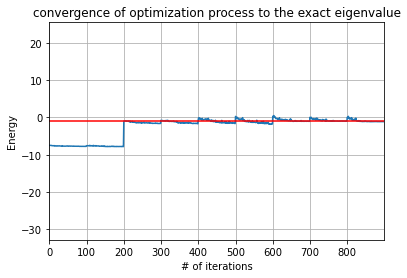

In [107]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [108]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

3it [00:00,  5.72it/s]
3it [00:00,  7.55it/s]
3it [00:00,  5.35it/s]
3it [00:00,  5.14it/s]
3it [00:00,  7.14it/s]
3it [00:00,  6.21it/s]
3it [00:00,  3.91it/s]
3it [00:00,  6.23it/s]
3it [00:00,  4.54it/s]
3it [00:00,  4.98it/s]
3it [00:00,  5.73it/s]
3it [00:00,  4.57it/s]
3it [00:00,  5.34it/s]
3it [00:00,  7.05it/s]
3it [00:00,  6.66it/s]
3it [00:00,  5.42it/s]
3it [00:00,  6.31it/s]
3it [00:00,  5.85it/s]
3it [00:00,  6.40it/s]
3it [00:00,  5.20it/s]
3it [00:00,  5.98it/s]
3it [00:00,  6.21it/s]
3it [00:00,  5.77it/s]
3it [00:00,  5.10it/s]
3it [00:00,  6.53it/s]
3it [00:00,  5.65it/s]
3it [00:00,  6.74it/s]
3it [00:00,  6.23it/s]
3it [00:00,  5.72it/s]
3it [00:00,  4.57it/s]
3it [00:00,  4.27it/s]
3it [00:00,  4.48it/s]
3it [00:00,  3.71it/s]
3it [00:00,  5.20it/s]
3it [00:00,  5.17it/s]
3it [00:00,  4.81it/s]
3it [00:00,  4.91it/s]
3it [00:00,  7.32it/s]
3it [00:00,  5.75it/s]
3it [00:00,  4.91it/s]
3it [00:00,  4.33it/s]
3it [00:00,  5.14it/s]
3it [00:00,  5.35it/s]
3it [00:00,

[196.57236194 260.34164431 216.67104216 176.01503215 239.49328343
  93.37805838 286.60317176  85.58686388 134.71077797 336.66297924
 306.84340101 168.28652062 208.96849519  22.77206035 257.70585072
 192.69495539]


3it [00:00,  6.23it/s]

CPU times: total: 36.8 s
Wall time: 55.3 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-1.1284190703420145

Approximation Error
0.09878001900117075


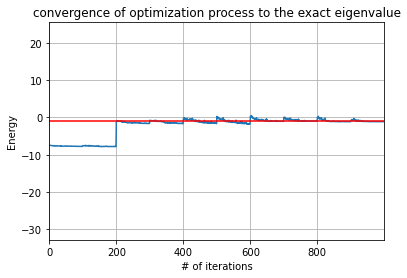

In [109]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [110]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

#### Linear Entangelment

In [111]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

4it [00:00,  5.05it/s]
4it [00:00,  6.10it/s]
4it [00:00,  5.89it/s]
4it [00:00,  6.54it/s]
4it [00:00,  5.67it/s]
4it [00:00,  5.48it/s]
4it [00:00,  7.53it/s]
4it [00:00,  7.01it/s]
4it [00:00,  7.89it/s]
4it [00:00,  8.12it/s]
4it [00:00,  7.73it/s]
4it [00:00,  7.62it/s]
4it [00:00,  6.07it/s]
4it [00:00,  6.81it/s]
4it [00:00,  6.57it/s]
4it [00:00,  7.46it/s]
4it [00:00,  5.24it/s]
4it [00:00,  5.09it/s]
4it [00:00,  5.23it/s]
4it [00:00,  6.95it/s]
4it [00:00,  8.21it/s]
4it [00:00,  6.13it/s]
4it [00:00,  5.38it/s]
4it [00:00,  4.31it/s]
4it [00:00,  5.35it/s]
4it [00:00,  5.55it/s]
4it [00:00,  4.14it/s]
4it [00:00,  6.24it/s]
4it [00:00,  5.50it/s]
4it [00:00,  5.94it/s]
4it [00:00,  8.11it/s]
4it [00:00,  8.58it/s]
4it [00:00,  7.11it/s]
4it [00:00,  6.40it/s]
4it [00:00,  5.62it/s]
4it [00:00,  5.74it/s]
4it [00:00,  5.47it/s]
4it [00:00,  5.96it/s]
4it [00:00,  6.43it/s]
4it [00:00,  6.43it/s]
4it [00:00,  5.87it/s]
4it [00:00,  4.90it/s]
4it [00:00,  4.80it/s]
4it [00:00,

[247.86461803 311.4654379  113.9902817  186.49171987 307.88850611
 297.02165696 206.34903705  41.44717915   6.36689909  70.28213504
 340.4312494  334.37025404 323.79495601  59.55817094 140.15442092
  51.69546235]


4it [00:00,  4.54it/s]

CPU times: total: 48.9 s
Wall time: 1min 11s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-1.0040665112866276

Approximation Error
0.001034908623683743


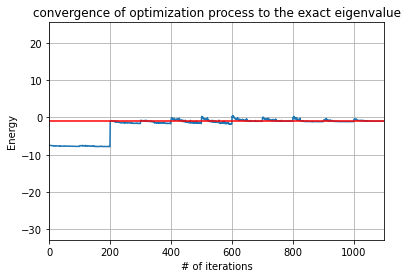

In [112]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [113]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

4it [00:00,  5.87it/s]
4it [00:00,  6.70it/s]
4it [00:00,  6.87it/s]
4it [00:00,  6.21it/s]
4it [00:00,  5.22it/s]
4it [00:00,  4.93it/s]
4it [00:00,  5.70it/s]
4it [00:00,  5.58it/s]
4it [00:00,  5.84it/s]
4it [00:00,  5.45it/s]
4it [00:00,  5.23it/s]
4it [00:00,  4.58it/s]
4it [00:00,  5.51it/s]
4it [00:00,  4.94it/s]
4it [00:01,  3.90it/s]
4it [00:00,  5.44it/s]
4it [00:00,  6.94it/s]
4it [00:00,  4.50it/s]
4it [00:00,  4.16it/s]
4it [00:00,  5.10it/s]
4it [00:00,  4.59it/s]
4it [00:00,  4.47it/s]
4it [00:00,  4.91it/s]
4it [00:00,  5.19it/s]
4it [00:00,  5.03it/s]
4it [00:00,  5.35it/s]
4it [00:00,  5.93it/s]
4it [00:00,  6.40it/s]
4it [00:00,  5.18it/s]
4it [00:00,  5.76it/s]
4it [00:00,  5.60it/s]
4it [00:00,  5.71it/s]
4it [00:00,  4.86it/s]
4it [00:00,  5.24it/s]
4it [00:00,  6.02it/s]
4it [00:00,  6.60it/s]
4it [00:00,  7.95it/s]
4it [00:00,  7.48it/s]
4it [00:00,  6.69it/s]
4it [00:00,  5.18it/s]
4it [00:00,  6.13it/s]
4it [00:00,  7.38it/s]
4it [00:00,  7.75it/s]
4it [00:00,

[212.05360693 316.82406922   5.30668566 137.87583911   9.11077431
 227.12677925 109.44472648 135.99143096  94.21838397 168.32145312
 297.12689761 152.91720141 246.3221586  231.16650813 343.0305528
 344.3877477 ]


4it [00:00,  5.64it/s]

CPU times: total: 48.5 s
Wall time: 1min 14s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.9454799052702043

Approximation Error
0.05932385021743172


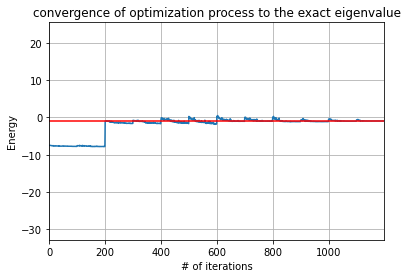

In [114]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)